In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})


In [2]:
from scipy.constants import e, m_p, c

from scipy.constants import physical_constants

In [3]:
from cpymad.madx import Madx

import pysixtracklib as pyst

### $\implies$ hard coded apertures in PySixTrackLib!!!

In [4]:
madx = Madx()
madx.options.echo = False
# madx.options.warn = False
# madx.options.info = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.04.02  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2018.10.03               +
  + Execution date: 2019.05.29 09:28:55      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [5]:
madxwarn = madx.options.warn
madx.options.warn = False
madx.call('./SIS100_RF_220618_9slices.thin.seq')
madx.options.warn = madxwarn

In [6]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
nmass = 0.931494061 # MAD-X value

In [7]:
madx.command.beam(particle='ion', mass=238*nmass, charge=28, energy=238*0.2+238*nmass)

True

In [8]:
# madxwarn = madx.options.warn
# madxinfo = madx.options.info
# madx.options.warn = False
# madx.options.info = False
# madx.call('./OpticsYEH_BeamParameters.str')
# madx.options.warn = madxwarn
# madx.options.info = madxinfo

In [9]:
madx.call('Coll+Errors+BeamDistr.madx')

In [10]:
#madx.call('Beam, sequence=SIS100RING, particle=U28, charge=charge_proj, mass=mass_proj, energy=energy_tot;')

In [11]:
madx.use(sequence='sis100ring')

uncomment and call this to create the error file if it is not already there:

In [12]:
# madx.call(file='track-noSpCh.madx')

In [13]:
len(madx.sequence.sis100ring.elements)

3707

In [22]:
madx.options.info = True
madx.options.warn = True
madx.options.echo = True

In [15]:
madx.input('''
select, flag=seqedit, class=collimator;
select, flag=seqedit, class=hmonitor;
select, flag=seqedit, class=vmonitor;
select, flag=seqedit, class=kicker;
select, flag=seqedit, class=tkicker;
select, flag=seqedit, class=dipedge;
select, flag=seqedit, class=elseparator;

seqedit, sequence=SIS100RING;
    remove, element=selected;
    flatten;
endedit;

select, flag=seqedit, class=marker;
seqedit, sequence=SIS100RING;
    remove, element=selected;
    install, element=SIS100RING$START, s=0;
    flatten;
endedit;
''')

++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    1631
++++++ info: seqedit - number of elements replaced:   0
++++++ warning: ignored, unknown command or element: (null)
++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    272
++++++ info: seqedit - number of elements replaced:   0


True

In [16]:
len(madx.sequence.sis100ring.elements)

1804

In [18]:
madx.use(sequence='sis100ring')

In [19]:
madx.input('''
match, sequence=SIS100RING;
global, sequence=SIS100RING, q1=18+0.84, q2=18+0.73;
vary, name=kqf, step=0.00001;
vary, name=kqd, step=0.00001;
lmdif, calls=500, tolerance=1.0e-10;
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: sis100ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   9.76233322e-14





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.80423e-01  2.81561e-01 -1.00000e+20  1.00000e+20
kqd                      -2.80318e-01 -2.80530e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   9.76233322e-14


True

# add magnet errors to actual lattice definition

In [26]:
filename_error_table = "./errors_84_73_1"

madx.command.readtable(file=filename_error_table, table="errors")
errors = madx.table.errors

Want to make named table: errors


In [27]:
# add multipole order errors to lattice:
relevant_errs = [category for category in errors.keys() 
                 if any(errors[category]) and category != 'name'
                 and category[:1] == 'k' and category[-1:] == 'l']

for el_idx, elem_name in enumerate(errors.name):
    el = madx.elements[elem_name]
    for category in relevant_errs:
        err_val = errors[category][el_idx]
        if not err_val:
            continue

        if not 's' in category:
            # normal knl component
            order = int(category[1:-1])
            try:
                el.knl[order] += err_val
            except IndexError:
                el.knl[order] = err_val
        else:
            # skew ksl component
            order = int(category[1:-2])
            try:
                el.ksl[order] += err_val
            except IndexError:
                el.ksl[order] = err_val

In [28]:
madx.use(sequence='SIS100RING')

In [29]:
madx.command.save(sequence='sis100ring', file=filename_error_table + '_full-lattice.seq')

++++++ warning: SAVE makes all previous USE invalid !  


True

In [30]:
madx.command.stop()


  Number of warnings: 8
8 in C and 0 in Fortran

  ++++++++++++++++++++++++++++++++++++++++++++
  +          MAD-X finished normally         +
  ++++++++++++++++++++++++++++++++++++++++++++


True

### $\implies$ missing dx, dy and dphi errors still!

# read in lattice with errors in full definition

In [31]:
madx = Madx()
madx.options.echo = False
# madx.options.warn = False
# madx.options.info = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.04.02  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2018.10.03               +
  + Execution date: 2019.05.29 09:30:56      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [32]:
madxwarn = madx.options.warn
madx.options.warn = False
madx.call(file=filename_error_table + '_full-lattice.seq')
madx.options.warn = madxwarn

In [33]:
madx.command.beam(particle='ion', mass=238*nmass, charge=28, energy=238*0.2+238*nmass)

True

In [34]:
madx.use(sequence='SIS100RING')

In [35]:
# madx.input('''
# select, flag=seqedit, class=collimator;
# select, flag=seqedit, class=hmonitor;
# select, flag=seqedit, class=vmonitor;
# select, flag=seqedit, class=kicker;
# select, flag=seqedit, class=tkicker;
# select, flag=seqedit, class=dipedge;
# select, flag=seqedit, class=elseparator;

# seqedit, sequence=SIS100RING;
#     remove, element=selected;
#     flatten;
# endedit;

# select, flag=seqedit, class=marker;
# seqedit, sequence=SIS100RING;
#     remove, element=selected;
#     install, element=SIS100RING$START, s=0;
#     flatten;
# endedit;
# ''')

In [36]:
madx.use(sequence='SIS100RING')

In [37]:
twiss = madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004026716913        15.75884742 

                q1                dq1            betxmax              dxmax 
       18.84004946       -36.61323035        20.24439745        3.066526854 

             dxrms             xcomax             xcorms                 q2 
       1.353969808                  0                  0        18.73003552 

               dq2            betymax              dymax              dyrms 
      -42.57489919        20.23824339      0.03748494188      0.01268944322 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [38]:
sis100 = madx.sequence.sis100ring

In [39]:
[f.name for f in map(lambda x: x.base_type, sis100.expanded_elements) 
 if 'drift' != f.name and 'multipole' != f.name and 'rfcavity' != f.name]

['marker', 'marker']

# Going to PySTL

In [40]:
elements = pyst.Elements.from_mad(sis100)

In [41]:
len(elements.get_elements())

3607

In [42]:
nturns = 2**16
elements.BeamMonitor(num_stores=nturns);

In [43]:
p0c = 238*0.2 * 1e9

In [44]:
npart = 1
particles = pyst.Particles.from_ref(npart, p0c=p0c)

In [45]:
particles.x += 1e-6
particles.y += 1e-6

In [46]:
job = pyst.TrackJob(elements, particles)

In [47]:
job.track(nturns)

0

In [48]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

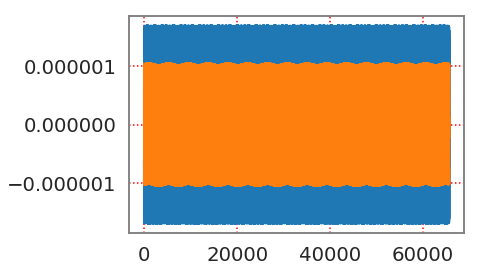

In [49]:
plt.plot(rec_x)
plt.plot(rec_y)

In [50]:
Qx = twiss.summary['q1']
qx = Qx % 1
qx = qx if qx < 0.5 else 1 - qx

Qy = twiss.summary['q2']
qy = Qy % 1
qy = qy if qy < 0.5 else 1 - qy

Text(0.5, 1.06, 'SIS100: single particle tracking in PySixTrackLib')

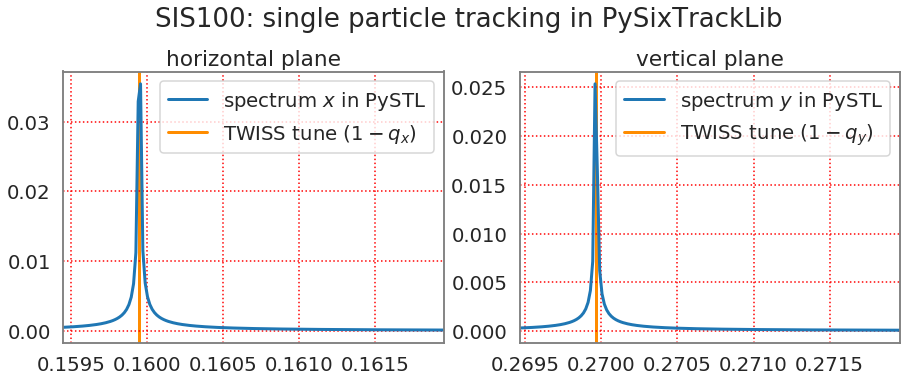

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal plane')
plt.plot(
    np.fft.rfftfreq(len(rec_x)),
    np.abs(np.fft.rfft(rec_x)),
    label=r'spectrum $x$ in PySTL'
)
plt.axvline(qx, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_x)$')
plt.xlim(qx - 0.0005, qx + 0.002)
plt.legend()

plt.sca(ax[1])
plt.title('vertical plane')
plt.plot(
    np.fft.rfftfreq(len(rec_y)),
    np.abs(np.fft.rfft(rec_y)),
    label=r'spectrum $y$ in PySTL'
)
plt.axvline(qy, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_y)$')
plt.xlim(qy - 0.0005, qy + 0.002)
plt.legend()

plt.suptitle('SIS100: single particle tracking in PySixTrackLib', y=1.06, fontsize=26)
# plt.savefig('./pystl_sis100_tunes.pdf', bbox_inches='tight')